In [15]:
import gpflow
import numpy as np
import matplotlib
from gpflow.utilities import print_summary
import pandas as pd
gpflow.config.set_default_summary_fmt("notebook")

# The lines below are specific to the notebook format
%matplotlib inline
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
matplotlib.rcParams.update(params)
plt = matplotlib.pyplot

# Import and inspect data

In [16]:
datafile = '/Users/litz/Documents/GitHub/data/sg_simple_grid_mixed_modes/m1.0_feh0.5_MLT1.9_fov0.018.csv'
data = pd.read_csv(datafile)
mode_l = '0'
mode_n = ['10', '20']

#mode_freq = 'nu_'+ mode_l + '_' +  mode_n
#mode_inertia = 'E_'+ mode_l + '_' + mode_n

#mode_freq = ['nu_0_%s' % s for s in mode_n]
#mode_inertia = ['E_0_%s' % s for s in mode_n]

sub_df_name = ['initial_mass','initial_feh','star_age','effective_T','radius','log_g','nu_max','delta_nu','delta_Pg']
logcolumns = ['star_age','effective_T','radius','nu_max','delta_nu']

sub_df_name = np.array(sub_df_name)
logcolumns = np.array(logcolumns)

print(sub_df_name)
sub_df = data[sub_df_name]
sub_df[logcolumns] = np.log10(sub_df[logcolumns])
sub_df = sub_df.replace([np.inf, -np.inf], np.nan)
sub_df.isna().sum()
sub_df = sub_df.dropna()
sub_df = sub_df.sample(frac = 0.60, random_state=20)
sub_df = sub_df.sort_index()
print(len(sub_df['star_age']))
sub_df.head()



['initial_mass' 'initial_feh' 'star_age' 'effective_T' 'radius' 'log_g'
 'nu_max' 'delta_nu' 'delta_Pg']
1020


,initial_mass,initial_feh,star_age,effective_T,radius,log_g,nu_max,delta_nu,delta_Pg
0,1.0,0.5,-5.000000,3.641085,1.463287,1.511315,0.623693,-0.064494,0.0
1,1.0,0.5,-4.657577,3.640680,1.463265,1.511359,0.623940,-0.064461,0.0
4,1.0,0.5,-4.128334,3.638990,1.463176,1.511537,0.624963,-0.064328,0.0
6,1.0,0.5,-3.888875,3.637349,1.463087,1.511716,0.625961,-0.064194,0.0
7,1.0,0.5,-3.832461,3.636805,1.463057,1.511776,0.626294,-0.064149,0.0


Text(0, 0.5, '$\\log(T_{\\rm eff})$ (K)')

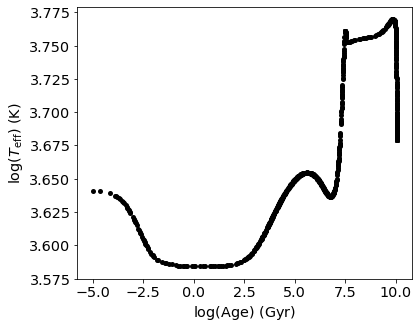

In [17]:
#data = np.genfromtxt('data/regression_1D.csv', delimiter=',')
#X = data[:, 0].reshape(-1, 1)
#Y = data[:, 1].reshape(-1, 1)

age = sub_df['star_age'].to_numpy().reshape(-1, 1)
teff = sub_df['effective_T'].to_numpy().reshape(-1, 1)
radius = sub_df['radius'].to_numpy().reshape(-1, 1)
log_g = sub_df['log_g'].to_numpy().reshape(-1, 1)
nu_max = sub_df['nu_max'].to_numpy().reshape(-1, 1)
delta_nu = sub_df['delta_nu'].to_numpy().reshape(-1, 1)
delta_Pg = sub_df['delta_Pg'].to_numpy().reshape(-1, 1)

X = age
Y = teff

plt.plot(X, Y, 'k.', mew=2);
plt.xlabel(r'$\log$(Age) (Gyr)')
plt.ylabel(r'$\log(T_{\rm eff})$ (K)')

# Set up and inspect Kernels

In [18]:
#basic kernels
constant = gpflow.kernels.Constant(variance=1.0, active_dims=None)
linear = gpflow.kernels.Linear(variance=1.0, active_dims=None)
poly2 = gpflow.kernels.Polynomial(degree=2.0, variance=1.0, offset=1.0, active_dims=None)
poly3 = gpflow.kernels.Polynomial(degree=3.0, variance=1.0, offset=1.0, active_dims=None)
poly4 = gpflow.kernels.Polynomial(degree=4.0, variance=1.0, offset=1.0, active_dims=None)
cosine = gpflow.kernels.Cosine(variance=1.0, lengthscale=1.0)
arccosine = gpflow.kernels.ArcCosine(order=0, variance=1.0, weight_variances=1.0, bias_variance=1.0, active_dims=None)
exponential = gpflow.kernels.Exponential(variance=1.0, lengthscale=1.0)# f = ab^x

#The periodic family of kernels. 
periodic = gpflow.kernels.Periodic(period=1.0)

#The radial basis function or squared exponential kernel
se = gpflow.kernels.SquaredExponential(variance=1.0, lengthscale=1.0)
#Rational Quadratic kernel: adding together many se(rbf) kernels with different lengthscales
rq = gpflow.kernels.RationalQuadratic(variance=1.0, lengthscale=1.0, alpha=1.0, active_dims=None)

#The Matern 1/2 kernel. Functions drawn from a GP with this kernel are not differentiable anywhere.
matern12 = gpflow.kernels.Matern12(variance=1.0, lengthscale=1.0)
#The Matern 3/2 kernel. Functions drawn from a GP with this kernel are once differentiable.
matern32 = gpflow.kernels.Matern32(variance=1.0, lengthscale=1.0)
#The Matern 5/2 kernel. Functions drawn from a GP with this kernel are twice differentiable. 
matern52 = gpflow.kernels.Matern52(variance=1.0, lengthscale=1.0)

#Kernels who don’t depend on the value of the inputs are ‘Static’. The only parameter is a variance, σ².
static = gpflow.kernels.Static(variance=1.0, active_dims=None)
#The White kernel: this kernel produces ‘white noise’
white = gpflow.kernels.White(variance=1.0, active_dims=None)

#other useful lines
#gpflow.kernels.ChangePoints(kernels, locations, steepness=1.0, name=None)
#gpflow.kernels.Combination(kernels, name=None)
#gpflow.kernels.LinearCoregionalization(kernels, W, name=None) #e.g correlated data sets two mixed modes 

#Multi Output Kernel class. This kernel can represent correlation between outputs of different datapoints. 
#gpflow.kernels.MultioutputKernel(active_dims=None, name=None)

k = matern12
print_summary(k, fmt = "notebook")

name,class,transform,trainable,shape,dtype,value
Matern12.variance,Parameter,Softplus,True,(),float64,1
Matern12.lengthscale,Parameter,Softplus,True,(),float64,1


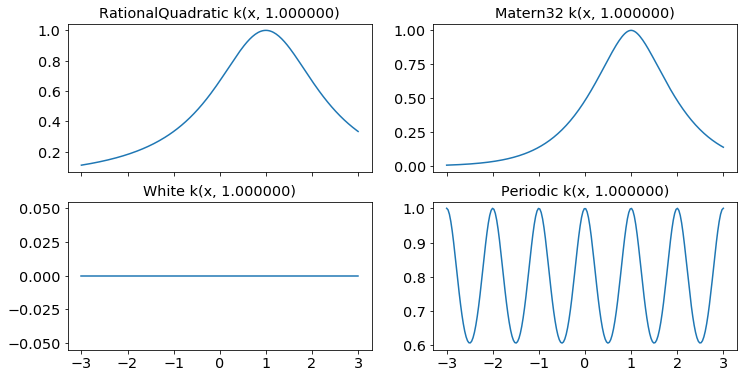

In [19]:
def plotkernelfunction(k, ax, xmin=-3, xmax=3, other=0):
    xx = np.linspace(xmin, xmax, 200)[:,None]
    ax.plot(xx, k(xx, np.zeros((1,1)) + other))
    ax.set_title(k.__class__.__name__ + ' k(x, %f)'%other)

f, axes = plt.subplots(2, 2, figsize=(12, 6), sharex=True)
plotkernelfunction(rq, axes[0, 0], other=1.)
plotkernelfunction(matern32, axes[0, 1], other=1.)
plotkernelfunction(white, axes[1, 0], other=1.)
plotkernelfunction(periodic, axes[1, 1], other=1.)

In [20]:
def objective_closure():
    return - m.log_marginal_likelihood()

In [6]:
m = gpflow.models.GPR(data=(X, Y), kernel=k, mean_function=None)
print_summary(m, fmt = "notebook")

name,class,transform,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,True,(),float64,1
GPR.kernel.lengthscale,Parameter,Softplus,True,(),float64,1
GPR.likelihood.variance,Parameter,Softplus,True,(),float64,1


# set up kernel parameters 
Set up an initial guessing of one parameter or fix its value by turning off the trainable

In [7]:
#m.likelihood.variance.assign(0.1)
#m.kernel.kernels[1].lengthscale.assign(0.3)
#m.kernel.kernels[1].variance.trainable = False

# set up parameter priors
set up a prob distribution for a parameter

In [8]:
#k = gpflow.kernels.Matern32()
#k.variance.prior = tfp.distributions.Gamma(
#    to_default_float(2), to_default_float(3))

# Optimizers
There are several Optimizers
gpflow.optimizers.Scipy uses minimize(self, closure, …). Minimize is a wrapper around the scipy.optimize.minimize function handling the packing and unpacking of a list of shaped variables on the TensorFlow side vs.the flat numpy array required on the Scipy side.

In [12]:
opt = gpflow.optimizers.Scipy()

In [ ]:
opt_logs = opt.minimize(objective_closure,
                        m.trainable_variables,
                        options=dict(maxiter=100))
print_summary(m, fmt = "notebook")

# test results

In [ ]:
## generate test points for prediction
xx = X  # test points must be of shape (N, D)

## predict mean and variance of latent GP at test points
mean, var = m.predict_f(xx)

## generate 10 samples from posterior
samples = m.predict_f_samples(xx, 10)  # shape (10, 100, 1)

## plot 
plt.figure(figsize=(12, 6))
plt.plot(X, Y, 'k.', mew=2)
plt.errorbar(xx, mean, yerr = var,c ='C0', lw=2)
plt.fill_between(xx[:,0],
                 mean[:,0] - 1.96 * np.sqrt(var[:,0]),
                 mean[:,0] + 1.96 * np.sqrt(var[:,0]),
                 color='C0', alpha=0.2)

plt.plot(xx, samples[:, :, 0].numpy().T, 'C0', linewidth=.5)
#plt.xlim(-0.1, 1.1);

name,class,transform,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,True,(),float64,7.75979
GPR.kernel.lengthscale,Parameter,Softplus,True,(),float64,0.392158
GPR.likelihood.variance,Parameter,Softplus,True,(),float64,9.13432e-06


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.


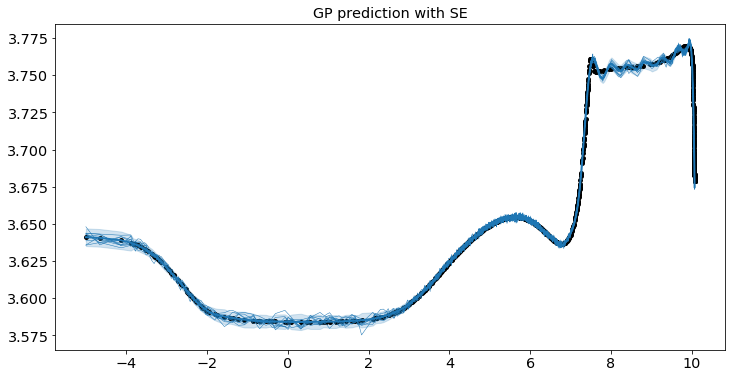

In [12]:
k = se
m = gpflow.models.GPR(data=(X, Y), kernel=k, mean_function=None)
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(objective_closure,
                        m.trainable_variables,
                        options=dict(maxiter=100))
print_summary(m, fmt = "notebook")
# generate test points for prediction
xx = X  # test points must be of shape (N, D)

## predict mean and variance of latent GP at test points
mean, var = m.predict_f(xx)

## generate 10 samples from posterior
samples = m.predict_f_samples(xx, 10)  # shape (10, 100, 1)

## plot 
plt.figure(figsize=(12, 6))
plt.plot(X, Y, 'k.', mew=2)
plt.errorbar(xx, mean, yerr = var,c ='C0', lw=2)
plt.title('GP prediction with SE')
plt.fill_between(xx[:,0],
                 mean[:,0] - 1.96 * np.sqrt(var[:,0]),
                 mean[:,0] + 1.96 * np.sqrt(var[:,0]),
                 color='C0', alpha=0.2)

plt.plot(xx, samples[:, :, 0].numpy().T, 'C0', linewidth=.5)
#plt.xlim(-0.1, 1.1);

name,class,transform,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,True,(),float64,10.9878
GPR.kernel.lengthscale,Parameter,Softplus,True,(),float64,113970
GPR.likelihood.variance,Parameter,Softplus,True,(),float64,2.64233e-14


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in sqrt


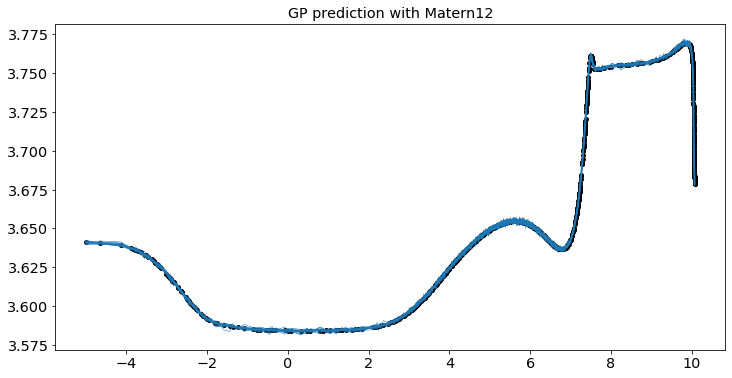

In [14]:
k = c
m = gpflow.models.GPR(data=(X, Y), kernel=k, mean_function=None)
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(objective_closure,
                        m.trainable_variables,
                        options=dict(maxiter=100))
print_summary(m, fmt = "notebook")
# generate test points for prediction
xx = X  # test points must be of shape (N, D)

## predict mean and variance of latent GP at test points
mean, var = m.predict_f(xx)

## generate 10 samples from posterior
samples = m.predict_f_samples(xx, 10)  # shape (10, 100, 1)

## plot 
plt.figure(figsize=(12, 6))
plt.plot(X, Y, 'k.', mew=2)
plt.errorbar(xx, mean, yerr = var,c ='C0', lw=2)
plt.title('GP prediction with Matern12')
plt.fill_between(xx[:,0],
                 mean[:,0] - 1.96 * np.sqrt(var[:,0]),
                 mean[:,0] + 1.96 * np.sqrt(var[:,0]),
                 color='C0', alpha=0.2)

plt.plot(xx, samples[:, :, 0].numpy().T, 'C0', linewidth=.5)
#plt.xlim(-0.1, 1.1);

name,class,transform,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,True,(),float64,3.72561
GPR.kernel.lengthscale,Parameter,Softplus,True,(),float64,5.71715
GPR.kernel.alpha,Parameter,Softplus,True,(),float64,6.35222e-06
GPR.likelihood.variance,Parameter,Softplus,True,(),float64,2.12252e-12


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.


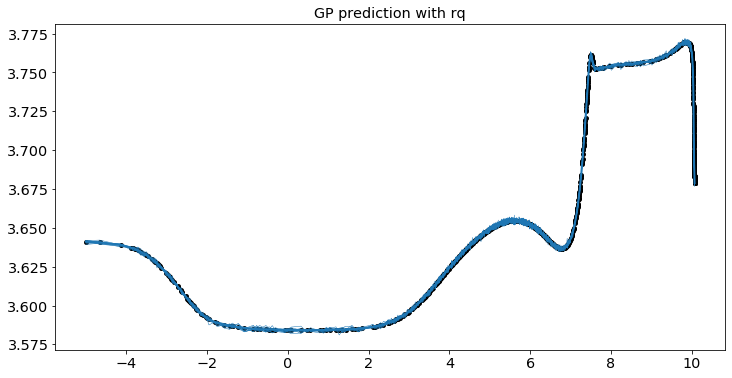

In [19]:
k = rq
m = gpflow.models.GPR(data=(X, Y), kernel=k, mean_function=None)
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(objective_closure,
                        m.trainable_variables,
                        options=dict(maxiter=100))
print_summary(m, fmt = "notebook")
# generate test points for prediction
xx = X  # test points must be of shape (N, D)

## predict mean and variance of latent GP at test points
mean, var = m.predict_f(xx)

## generate 10 samples from posterior
samples = m.predict_f_samples(xx, 10)  # shape (10, 100, 1)

## plot 
plt.figure(figsize=(12, 6))
plt.plot(X, Y, 'k.', mew=2)
plt.errorbar(xx, mean, yerr = var,c ='C0', lw=2)
plt.title('GP prediction with rq')
plt.fill_between(xx[:,0],
                 mean[:,0] - 1.96 * np.sqrt(var[:,0]),
                 mean[:,0] + 1.96 * np.sqrt(var[:,0]),
                 color='C0', alpha=0.2)

plt.plot(xx, samples[:, :, 0].numpy().T, 'C0', linewidth=.5)
#plt.xlim(-0.1, 1.1);

name,class,transform,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance GPR.kernel.kernels[1].variance,Parameter,Softplus,True,(),float64,4.81092
GPR.kernel.kernels[0].lengthscale GPR.kernel.kernels[1].lengthscale,Parameter,Softplus,True,(),float64,0.112977
GPR.likelihood.variance,Parameter,Softplus,True,(),float64,1.7205e-06


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.


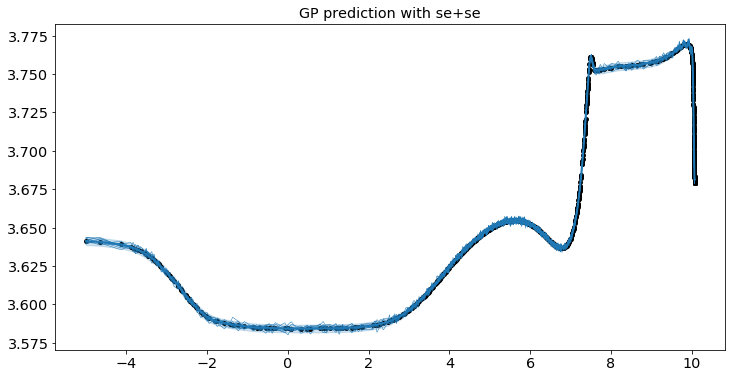

In [25]:
k = se + se
m = gpflow.models.GPR(data=(X, Y), kernel=k, mean_function=None)
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(objective_closure,
                        m.trainable_variables,
                        options=dict(maxiter=100))
print_summary(m, fmt = "notebook")
# generate test points for prediction
xx = X  # test points must be of shape (N, D)

## predict mean and variance of latent GP at test points
mean, var = m.predict_f(xx)

## generate 10 samples from posterior
samples = m.predict_f_samples(xx, 10)  # shape (10, 100, 1)

## plot 
plt.figure(figsize=(12, 6))
plt.plot(X, Y, 'k.', mew=2)
plt.errorbar(xx, mean, yerr = var,c ='C0', lw=2)
plt.title('GP prediction with se+se')
plt.fill_between(xx[:,0],
                 mean[:,0] - 1.96 * np.sqrt(var[:,0]),
                 mean[:,0] + 1.96 * np.sqrt(var[:,0]),
                 color='C0', alpha=0.2)

plt.plot(xx, samples[:, :, 0].numpy().T, 'C0', linewidth=.5)
#plt.xlim(-0.1, 1.1);